### Imports

In [21]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
import math
import numpy as np
import  wandb
import os
import time

from torchmetrics import Dice
import segmentation_models_pytorch as smp

## depend to the files of the project
import utils 
from utils import load, save, plot
from benchmark import dataset
from Unet import unet
from utils import load, save, plot

### Loading the WandB

In [22]:
key_file = './wandb-key.txt'

if os.path.exists(key_file):
    with open(key_file) as f:
        key = f.readline().strip()
    wandb.login(key=key)
else:
    print("Key file does not exist. Please create the key file with your wandb API key.")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


### Arguments

In [26]:
seed = 3
wandb_enable = True

info = {'num_epoch' :10,
        'lr' : 0.3,
        'weight_decay' : 0.0001,
        'device' : 'cuda',
        'reset': True,
        'name_load' : 'unet-efficientnet-encoder',
        'model_load_path' : './saved_model/',
        'model_save_path' : './saved_model/'
        }



Initialize `wandb`

In [27]:
wandb_arg_name = 'unet-efficientnet-encoder' # name of this training process
wandb.init(
        project='Medical Image Segmentation',  # name of the project
        name=wandb_arg_name,
        config={
            'lr': info['lr'],
            'weight_decay': info['weight_decay'],
            'num_epoch': info['num_epoch']
        }
    )


loss_train,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_valid,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metric_train,▁▆▇▇▇█████████████████████████
metric_valid,▁▄▆▇▇█████████████████████████
loss_train,0.14376
loss_valid,0.19855
metric_train,0.84981
metric_valid,0.79257


### Main Loop

In [28]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

Deffine the `Dataloader`

In [6]:
train_batch_size = 32
valid_batch_size = 64

train_loader = dataset.UW_madison(root='./benchmark/UW_madison_dataset', mode='train', mini=False, memory=True)(batch_size=train_batch_size)
valid_loader = dataset.UW_madison(root='./benchmark/UW_madison_dataset', mode='valid', mini=False, memory=False)(batch_size=valid_batch_size)

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


 Define the `Model` - `Optimizer` - `Loss Function` - `Metric`

In [31]:
load_path = info['model_load_path'] + info['name_load'] + ".pth"

##  Model
# model = unet.UNet(n_channels=3, n_classes=3, bilinear=False).to(info['device'])
model = smp.Unet(encoder_name='efficientnet-b1', encoder_weights='imagenet',
                in_channels=3, classes=3).to(info['device'])

optimizer = optim.SGD(model.parameters(), lr=info['lr'], weight_decay=info['weight_decay'], momentum=0.9)# , nesterov=True
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.1)

loss_fn = smp.losses.DiceLoss(mode='multilabel')

metric = Dice().to(info['device'])

model, loss_fn, _ = load(model, loss_fn, optimizer, device=info['device'], reset = info['reset'], load_path = load_path)

save_path = info['model_save_path'] + info['name_load']+ ".pth"

**`Training`**

In [34]:
epochs = info['num_epoch']

for epoch in range(1, epochs+1):
    ## Train
    model, loss_train, metric_train = utils.train_one_epoch(model,
                                                            train_loader,
                                                            loss_fn,
                                                            optimizer,
                                                            metric,
                                                            epoch,
                                                            device=info['device'])
    
    ## Validation
    loss_valid, metric_valid = utils.evaluate(model,
                                              valid_loader,
                                              loss_fn,
                                              metric,
                                              device=info['device'])

        
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)


    print(f'Train      - Loss:{loss_train}  Metric:{metric_train}')
    print(f'Validation - Loss:{loss_valid}  Metric:{metric_valid}')
    print(f'LR = {lr_scheduler.get_last_lr()[0]}')
    print()

    if loss_valid < best_loss_valid:
        save(save_path, model, optimizer, loss_fn)
        best_loss_valid = loss_valid
        print('Model Saved ("o")')

    if wandb_enable:
        wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                   "metric_valid": metric_valid, "loss_valid": loss_valid})
        
    lr_scheduler.step()

    epoch_counter += 1





  0%|          | 0/376 [00:00<?, ?batch/s]

Epoch 1: 100%|██████████| 376/376 [04:50<00:00,  1.29batch/s, loss=0.128, metric=0.867]


Train      - Loss:0.1281629204750061  Metric:0.8667187094688416
Validation - Loss:0.19522221386432648  Metric:0.7975568175315857
LR = 0.003



Epoch 2: 100%|██████████| 376/376 [04:50<00:00,  1.30batch/s, loss=0.128, metric=0.867]


Train      - Loss:0.12798753380775452  Metric:0.8666650652885437
Validation - Loss:0.19620934128761292  Metric:0.7957669496536255
LR = 0.003



Epoch 3: 100%|██████████| 376/376 [04:50<00:00,  1.30batch/s, loss=0.127, metric=0.868]


Train      - Loss:0.12749432027339935  Metric:0.8675058484077454
Validation - Loss:0.19598370790481567  Metric:0.7961959838867188
LR = 0.003



Epoch 4: 100%|██████████| 376/376 [04:49<00:00,  1.30batch/s, loss=0.127, metric=0.868]


Train      - Loss:0.1274842470884323  Metric:0.8675712943077087
Validation - Loss:0.19504283368587494  Metric:0.7969017624855042
LR = 0.003



Epoch 5: 100%|██████████| 376/376 [04:50<00:00,  1.30batch/s, loss=0.127, metric=0.868]


Train      - Loss:0.12734107673168182  Metric:0.8676179647445679
Validation - Loss:0.1959083378314972  Metric:0.7959564328193665
LR = 0.003



Epoch 6: 100%|██████████| 376/376 [04:50<00:00,  1.29batch/s, loss=0.127, metric=0.868]


Train      - Loss:0.12694549560546875  Metric:0.8681707382202148
Validation - Loss:0.1978844255208969  Metric:0.7943012714385986
LR = 0.00030000000000000003



Epoch 7: 100%|██████████| 376/376 [04:50<00:00,  1.30batch/s, loss=0.127, metric=0.868]


Train      - Loss:0.12691918015480042  Metric:0.86807781457901
Validation - Loss:0.1982458531856537  Metric:0.7938780784606934
LR = 0.00030000000000000003



Epoch 8: 100%|██████████| 376/376 [04:50<00:00,  1.30batch/s, loss=0.127, metric=0.868]


Train      - Loss:0.12666712701320648  Metric:0.8682587146759033
Validation - Loss:0.19484572112560272  Metric:0.7962806820869446
LR = 0.00030000000000000003



Epoch 9: 100%|██████████| 376/376 [04:50<00:00,  1.30batch/s, loss=0.126, metric=0.868]


Train      - Loss:0.12628445029258728  Metric:0.8684656023979187
Validation - Loss:0.1977585107088089  Metric:0.7939775586128235
LR = 0.00030000000000000003



Epoch 10: 100%|██████████| 376/376 [04:50<00:00,  1.30batch/s, loss=0.127, metric=0.868]


Train      - Loss:0.12696734070777893  Metric:0.8680219054222107
Validation - Loss:0.19721098244190216  Metric:0.7948127388954163
LR = 0.00030000000000000003



In [35]:
wandb.finish()

loss_train,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_valid,█▆▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metric_train,▁▇▇▇▇█████████████████████████
metric_valid,▁▃▅▆▆███▇█████████████████████
loss_train,0.12697
loss_valid,0.19721
metric_train,0.86802
metric_valid,0.79481


In [37]:
save(save_path, model, optimizer, loss_fn)

### Plot learning curves


Trained 30 epochs


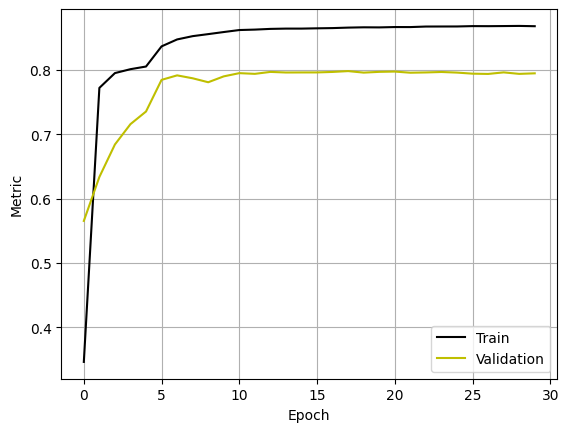


Trained 30 epochs


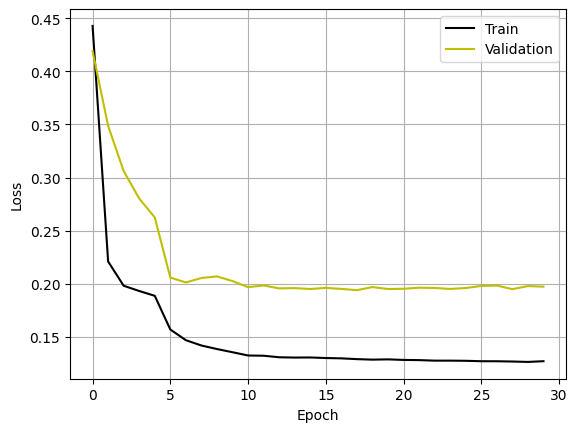

In [36]:
plot(metric_train_hist, metric_valid_hist, "Metric")
plot(loss_train_hist, loss_valid_hist, 'Loss')